Построенный маршрут: [0, 11]


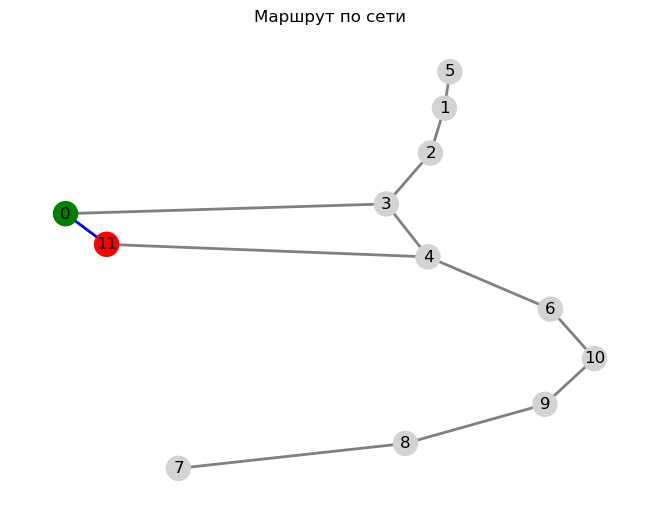

In [2]:
import tensorflow as tf
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random

# Генерация графа
def generate_network(num_nodes=10):
    G = nx.connected_watts_strogatz_graph(num_nodes, k=3, p=0.5)
    for u, v in G.edges():
        G[u][v]['latency'] = random.uniform(1, 10)
        G[u][v]['packet_loss'] = random.uniform(0.01, 0.1)
        G[u][v]['load'] = random.uniform(0.1, 1.0)
        G[u][v]['status'] = random.choice([1.0, 1.0, 1.0, 0.0])
    return G

# Модель
def create_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Обучение модели на синтетических "хороших путях"
def train_model(G, model):
    X, y = [], []
    for path in nx.all_simple_paths(G, source=0, target=len(G.nodes)-1, cutoff=4):
        for i in range(len(path) - 1):
            u, v = path[i], path[i+1]
            data = G[u][v]
            X.append([data['latency'], data['packet_loss'], data['load'], data['status']])
            y.append(1.0)  # правильный маршрут
        for _ in range(3):  # негативные примеры
            u, v = random.choice(list(G.edges()))
            if [u, v] not in zip(path[:-1], path[1:]) and [v, u] not in zip(path[:-1], path[1:]):
                data = G[u][v]
                X.append([data['latency'], data['packet_loss'], data['load'], data['status']])
                y.append(0.0)
    X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
    model.fit(X, y, epochs=20, verbose=0)
    return model

# Пошаговое построение маршрута
def build_path(G, model, src, dst):
    path = [src]
    visited = set(path)
    while path[-1] != dst:
        current = path[-1]
        candidates = []
        for neighbor in G.neighbors(current):
            if neighbor in visited:
                continue
            data = G[current][neighbor]
            features = np.array([[data['latency'], data['packet_loss'], data['load'], data['status']]])
            score = model.predict(features, verbose=0)[0][0]
            candidates.append((score, neighbor))
        if not candidates:
            break  # путь не найден
        candidates.sort(reverse=True)
        next_node = candidates[0][1]
        path.append(next_node)
        visited.add(next_node)
    return path

# Визуализация графа и маршрута
def visualize_path(G, path):
    pos = nx.spring_layout(G, seed=42)
    edge_colors = ['blue' if (u in path and v in path and abs(path.index(u) - path.index(v)) == 1) else 'gray'
                   for u, v in G.edges()]

    node_colors = ['green' if n == path[0] else 'red' if n == path[-1] else 'lightgray' for n in G.nodes()]

    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors, width=2)
    plt.title("Маршрут по сети")
    plt.show()

# ==== Запуск ====
G = generate_network(12)
src, dst = 0, len(G.nodes) - 1

model = create_model(4)
train_model(G, model)

path = build_path(G, model, src, dst)
print("Построенный маршрут:", path)

visualize_path(G, path)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.75it/s]


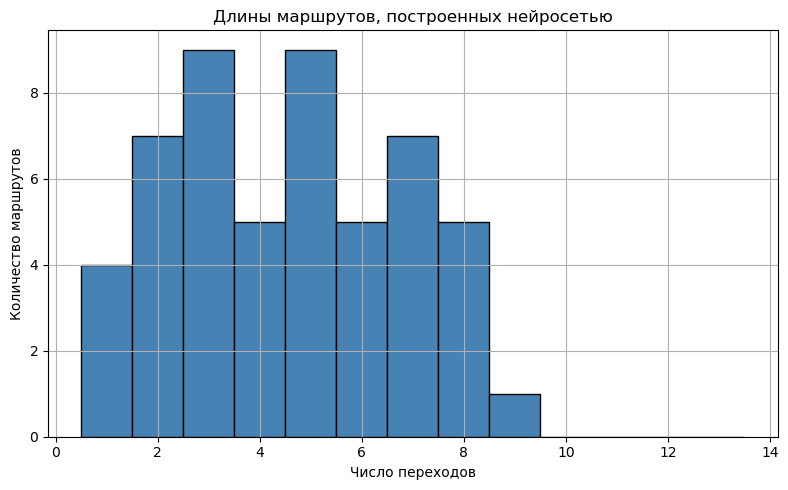

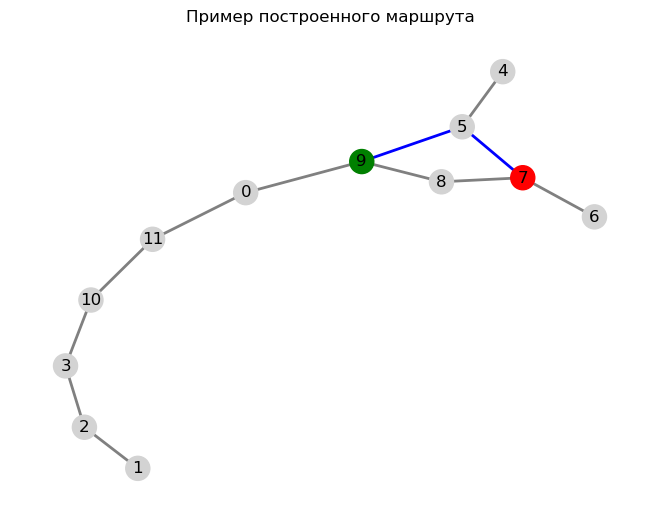

In [3]:
import tensorflow as tf
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# Генерация графа
def generate_network(num_nodes=12):
    G = nx.connected_watts_strogatz_graph(num_nodes, k=3, p=0.5)
    for u, v in G.edges():
        G[u][v]['latency'] = random.uniform(1, 10)
        G[u][v]['packet_loss'] = random.uniform(0.01, 0.1)
        G[u][v]['load'] = random.uniform(0.1, 1.0)
        G[u][v]['status'] = random.choice([1.0, 1.0, 1.0, 0.0])  # с вероятностью 25% — отказ
    return G

# Модель
def create_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Обучение модели на синтетических "хороших путях"
def train_model(G, model):
    X, y = [], []
    for path in nx.all_simple_paths(G, source=0, target=len(G.nodes)-1, cutoff=4):
        for i in range(len(path) - 1):
            u, v = path[i], path[i+1]
            data = G[u][v]
            X.append([data['latency'], data['packet_loss'], data['load'], data['status']])
            y.append(1.0)
        for _ in range(3):
            u, v = random.choice(list(G.edges()))
            if [u, v] not in zip(path[:-1], path[1:]) and [v, u] not in zip(path[:-1], path[1:]):
                data = G[u][v]
                X.append([data['latency'], data['packet_loss'], data['load'], data['status']])
                y.append(0.0)
    X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
    model.fit(X, y, epochs=20, verbose=0)
    return model

# Построение маршрута
def build_path(G, model, src, dst):
    path = [src]
    visited = set(path)
    while path[-1] != dst:
        current = path[-1]
        candidates = []
        for neighbor in G.neighbors(current):
            if neighbor in visited:
                continue
            data = G[current][neighbor]
            features = np.array([[data['latency'], data['packet_loss'], data['load'], data['status']]])
            score = model.predict(features, verbose=0)[0][0]
            candidates.append((score, neighbor))
        if not candidates:
            return None  # путь не найден
        candidates.sort(reverse=True)
        next_node = candidates[0][1]
        path.append(next_node)
        visited.add(next_node)
        if len(path) > len(G.nodes):  # защита от зацикливания
            return None
    return path

# ==== Запуск ====
G = generate_network(12)
model = create_model(4)
train_model(G, model)

num_packets = 100
paths = []
lengths = []

for _ in tqdm(range(num_packets)):
    src, dst = random.sample(list(G.nodes), 2)
    path = build_path(G, model, src, dst)
    if path:
        paths.append(path)
        lengths.append(len(path) - 1)
    else:
        lengths.append(0)

# Гистограмма длин маршрутов
plt.figure(figsize=(8, 5))
plt.hist([l for l in lengths if l > 0], bins=range(1, 15), color='steelblue', edgecolor='black', align='left')
plt.title("Длины маршрутов, построенных нейросетью")
plt.xlabel("Число переходов")
plt.ylabel("Количество маршрутов")
plt.grid(True)
plt.tight_layout()
plt.show()

# Пример визуализации одного маршрута
example_path = next((p for p in paths if p is not None), None)
if example_path:
    def visualize_path(G, path):
        pos = nx.spring_layout(G, seed=42)
        edge_colors = ['blue' if (u in path and v in path and abs(path.index(u) - path.index(v)) == 1) else 'gray'
                       for u, v in G.edges()]
        node_colors = ['green' if n == path[0] else 'red' if n == path[-1] else 'lightgray' for n in G.nodes()]
        nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors, width=2)
        plt.title("Пример построенного маршрута")
        plt.show()

    visualize_path(G, example_path)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.68it/s]


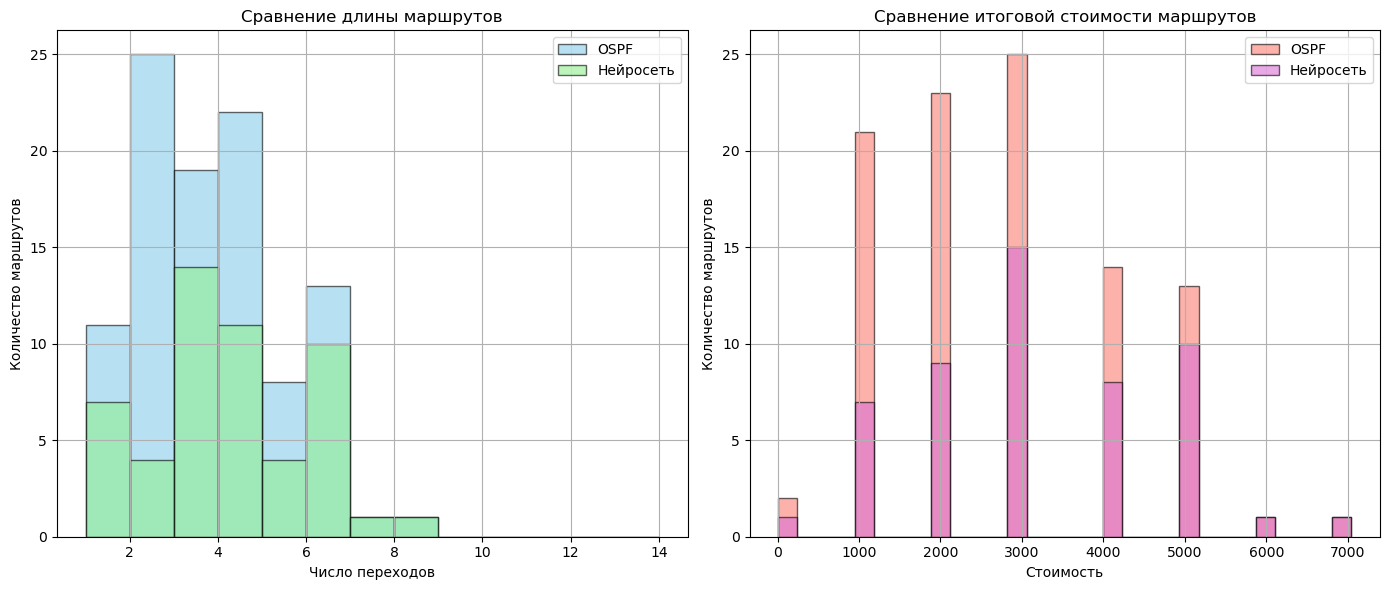

Средняя длина маршрута (OSPF): 3.39
Средняя длина маршрута (NN): 3.769230769230769
Средняя стоимость маршрута (OSPF): 2778.4807508246154
Средняя стоимость маршрута (NN): 3191.803666448517


In [4]:
import tensorflow as tf
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# Генерация графа
def generate_network(num_nodes=12):
    G = nx.connected_watts_strogatz_graph(num_nodes, k=3, p=0.5)
    for u, v in G.edges():
        G[u][v]['latency'] = random.uniform(1, 10)
        G[u][v]['packet_loss'] = random.uniform(0.01, 0.1)
        G[u][v]['load'] = random.uniform(0.1, 1.0)
        G[u][v]['status'] = random.choice([1.0, 1.0, 1.0, 0.0])
    return G

# Модель
def create_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Обучение модели
def train_model(G, model):
    X, y = [], []
    for path in nx.all_simple_paths(G, source=0, target=len(G.nodes)-1, cutoff=4):
        for i in range(len(path) - 1):
            u, v = path[i], path[i+1]
            data = G[u][v]
            X.append([data['latency'], data['packet_loss'], data['load'], data['status']])
            y.append(1.0)
        for _ in range(3):
            u, v = random.choice(list(G.edges()))
            if [u, v] not in zip(path[:-1], path[1:]) and [v, u] not in zip(path[:-1], path[1:]):
                data = G[u][v]
                X.append([data['latency'], data['packet_loss'], data['load'], data['status']])
                y.append(0.0)
    X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
    model.fit(X, y, epochs=20, verbose=0)
    return model

# Построение маршрута с моделью
def build_path_nn(G, model, src, dst):
    path = [src]
    visited = set(path)
    while path[-1] != dst:
        current = path[-1]
        candidates = []
        for neighbor in G.neighbors(current):
            if neighbor in visited:
                continue
            data = G[current][neighbor]
            features = np.array([[data['latency'], data['packet_loss'], data['load'], data['status']]])
            score = model.predict(features, verbose=0)[0][0]
            candidates.append((score, neighbor))
        if not candidates:
            return None
        candidates.sort(reverse=True)
        next_node = candidates[0][1]
        path.append(next_node)
        visited.add(next_node)
        if len(path) > len(G.nodes):
            return None
    return path

# Стоимость маршрута
def calculate_path_cost_multiobjective(G, path, alpha=1.0, beta=5.0, gamma=1.0, fault_penalty=1000):
    if not path or len(path) < 2:
        return float('inf')
    total_latency = 0.0
    total_loss = 0.0
    total_load = 0.0
    reliability_penalty = 0.0

    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        if G.has_edge(u, v):
            data = G[u][v]
            total_latency += data['latency']
            total_loss += data['packet_loss']
            total_load += data['load']
        else:
            return float('inf')

    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        G_copy = G.copy()
        G_copy.remove_edge(u, v)
        if not nx.has_path(G_copy, u, v):
            reliability_penalty += fault_penalty

    return alpha * total_latency + beta * total_loss + gamma * total_load + reliability_penalty

# ==== Запуск сравнения ====
G = generate_network(12)
model = create_model(4)
train_model(G, model)

num_packets = 100

nn_lengths, nn_costs = [], []
ospf_lengths, ospf_costs = [], []

for _ in tqdm(range(num_packets)):
    src, dst = random.sample(list(G.nodes), 2)

    # Нейросеть
    path_nn = build_path_nn(G, model, src, dst)
    nn_lengths.append(len(path_nn) - 1 if path_nn else 0)
    nn_costs.append(calculate_path_cost_multiobjective(G, path_nn))

    # OSPF
    try:
        path_ospf = nx.shortest_path(G, source=src, target=dst, weight='latency')
    except nx.NetworkXNoPath:
        path_ospf = None
    ospf_lengths.append(len(path_ospf) - 1 if path_ospf else 0)
    ospf_costs.append(calculate_path_cost_multiobjective(G, path_ospf))

# ==== Визуализация ====

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist([l for l in ospf_lengths if l > 0], bins=range(1, 15), alpha=0.6, label='OSPF', color='skyblue', edgecolor='black')
plt.hist([l for l in nn_lengths if l > 0], bins=range(1, 15), alpha=0.6, label='Нейросеть', color='lightgreen', edgecolor='black')
plt.title("Сравнение длины маршрутов")
plt.xlabel("Число переходов")
plt.ylabel("Количество маршрутов")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist([c for c in ospf_costs if c < 1e5], bins=30, alpha=0.6, label='OSPF', color='salmon', edgecolor='black')
plt.hist([c for c in nn_costs if c < 1e5], bins=30, alpha=0.6, label='Нейросеть', color='orchid', edgecolor='black')
plt.title("Сравнение итоговой стоимости маршрутов")
plt.xlabel("Стоимость")
plt.ylabel("Количество маршрутов")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ==== Средние значения ====
print("Средняя длина маршрута (OSPF):", np.mean([l for l in ospf_lengths if l > 0]))
print("Средняя длина маршрута (NN):", np.mean([l for l in nn_lengths if l > 0]))
print("Средняя стоимость маршрута (OSPF):", np.mean([c for c in ospf_costs if c < 1e5]))
print("Средняя стоимость маршрута (NN):", np.mean([c for c in nn_costs if c < 1e5]))


Маршрут OSPF: [9, 8, 7, 6, 5]
Маршрут NN:   [9, 8, 7, 6, 5]


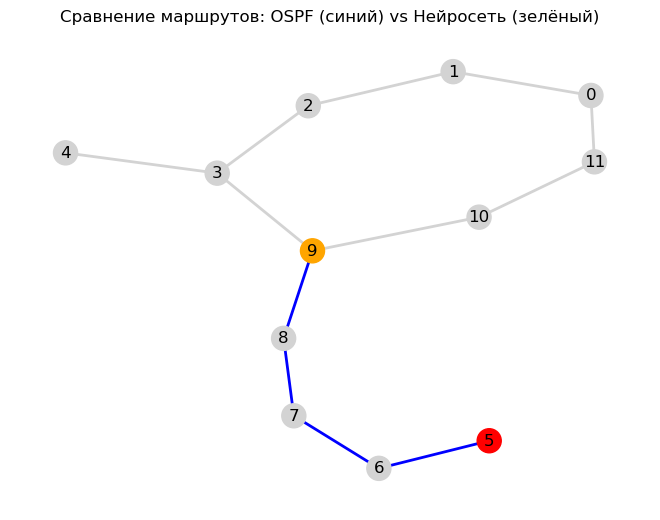

In [10]:
import tensorflow as tf
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random

# Генерация графа
def generate_network(num_nodes=12):
    G = nx.connected_watts_strogatz_graph(num_nodes, k=3, p=0.5)
    for u, v in G.edges():
        G[u][v]['latency'] = random.uniform(1, 10)
        G[u][v]['packet_loss'] = random.uniform(0.01, 0.1)
        G[u][v]['load'] = random.uniform(0.1, 1.0)
        G[u][v]['status'] = random.choice([1.0, 1.0, 1.0, 0.0])
    return G

# Создание и обучение модели
def create_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_model(G, model):
    X, y = [], []
    for path in nx.all_simple_paths(G, source=0, target=len(G.nodes)-1, cutoff=4):
        for i in range(len(path) - 1):
            u, v = path[i], path[i+1]
            data = G[u][v]
            X.append([data['latency'], data['packet_loss'], data['load'], data['status']])
            y.append(1.0)
        for _ in range(3):
            u, v = random.choice(list(G.edges()))
            if [u, v] not in zip(path[:-1], path[1:]) and [v, u] not in zip(path[:-1], path[1:]):
                data = G[u][v]
                X.append([data['latency'], data['packet_loss'], data['load'], data['status']])
                y.append(0.0)
    model.fit(np.array(X), np.array(y), epochs=20, verbose=0)
    return model

# Построение маршрута с помощью нейросети
def build_path_nn(G, model, src, dst):
    path = [src]
    visited = set(path)
    while path[-1] != dst:
        current = path[-1]
        candidates = []
        for neighbor in G.neighbors(current):
            if neighbor in visited:
                continue
            data = G[current][neighbor]
            features = np.array([[data['latency'], data['packet_loss'], data['load'], data['status']]])
            score = model.predict(features, verbose=0)[0][0]
            candidates.append((score, neighbor))
        if not candidates:
            return None
        candidates.sort(reverse=True)
        next_node = candidates[0][1]
        path.append(next_node)
        visited.add(next_node)
        if len(path) > len(G.nodes):
            return None
    return path

# Визуализация маршрутов
def visualize_comparison(G, path_ospf, path_nn, src, dst):
    pos = nx.spring_layout(G, seed=42)

    edge_colors = []
    for u, v in G.edges():
        if path_ospf and (u, v) in zip(path_ospf[:-1], path_ospf[1:]) or (v, u) in zip(path_ospf[:-1], path_ospf[1:]):
            edge_colors.append('blue')
        elif path_nn and (u, v) in zip(path_nn[:-1], path_nn[1:]) or (v, u) in zip(path_nn[:-1], path_nn[1:]):
            edge_colors.append('green')
        else:
            edge_colors.append('lightgray')

    node_colors = []
    for n in G.nodes():
        if n == src:
            node_colors.append('orange')
        elif n == dst:
            node_colors.append('red')
        else:
            node_colors.append('lightgray')

    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors, width=2)
    plt.title("Сравнение маршрутов: OSPF (синий) vs Нейросеть (зелёный)")
    plt.show()

# ==== Запуск ====
G = generate_network(12)
model = create_model(4)
train_model(G, model)

# Случайные узлы
src, dst = random.sample(list(G.nodes), 2)

# OSPF маршрут
try:
    path_ospf = nx.shortest_path(G, source=src, target=dst, weight='latency')
except nx.NetworkXNoPath:
    path_ospf = None

# NN маршрут
path_nn = build_path_nn(G, model, src, dst)

print("Маршрут OSPF:", path_ospf)
print("Маршрут NN:  ", path_nn)

visualize_comparison(G, path_ospf, path_nn, src, dst)


In [11]:
import numpy as np
import networkx as nx
import random
import tensorflow as tf

# ===== Состояние узлов (очереди)
class NodeState:
    def __init__(self, num_nodes):
        self.busy_until = [0] * num_nodes  # время, до которого узел занят

    def is_available(self, node, current_time):
        return self.busy_until[node] <= current_time

    def reserve(self, node, current_time, duration=2):
        self.busy_until[node] = current_time + duration

# ===== Построение маршрута с учётом занятости
def build_path_with_time(G, model, src, dst, node_state, start_time=0):
    path = [src]
    visited = set(path)
    time = start_time
    node_state.reserve(src, time)  # резервируем отправку с src

    while path[-1] != dst:
        current = path[-1]
        candidates = []
        for neighbor in G.neighbors(current):
            if neighbor in visited:
                continue
            if not node_state.is_available(neighbor, time + 1):  # задержка между узлами = 1
                continue
            data = G[current][neighbor]
            features = np.array([[data['latency'], data['packet_loss'], data['load'], data['status']]])
            score = model.predict(features, verbose=0)[0][0]
            candidates.append((score, neighbor))

        if not candidates:
            return None

        candidates.sort(reverse=True)
        next_node = candidates[0][1]

        path.append(next_node)
        visited.add(next_node)

        # Резервируем узел на 2 единицы времени с учётом перехода
        time += 1
        node_state.reserve(next_node, time)
        time += 1  # затраты на отправку

        if len(path) > len(G.nodes):
            return None
    return path


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 176.96it/s]


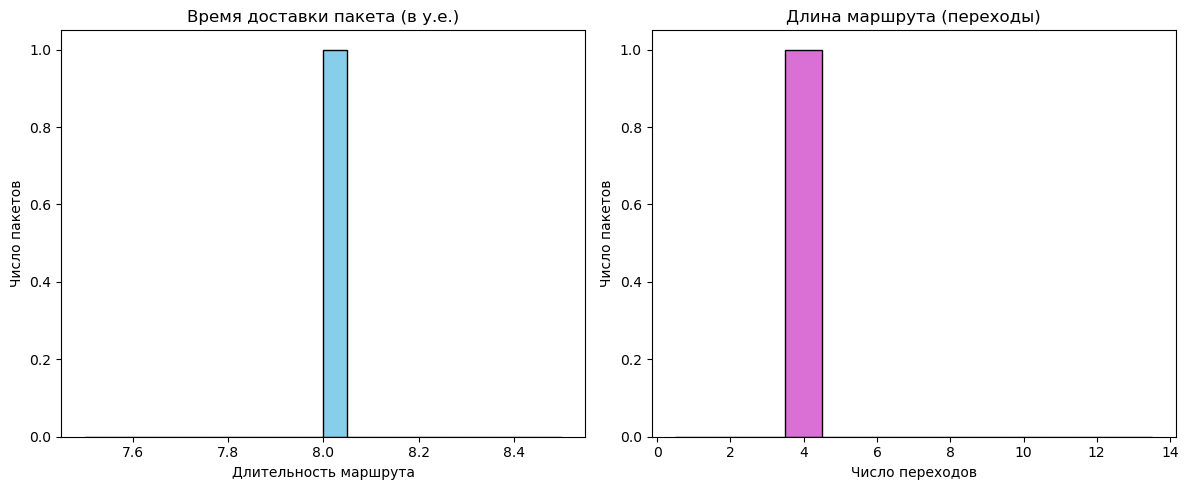

In [17]:
# Повтор выполнения без Markdown-артефактов

import numpy as np
import networkx as nx
import random
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

# ===== Генерация графа =====
def generate_network(num_nodes=12):
    G = nx.connected_watts_strogatz_graph(num_nodes, k=3, p=0.5)
    for u, v in G.edges():
        G[u][v]['latency'] = 1.0  # фиксированная задержка
        G[u][v]['packet_loss'] = random.uniform(0.01, 0.1)
        G[u][v]['load'] = random.uniform(0.1, 1.0)
        G[u][v]['status'] = random.choice([1.0, 1.0, 1.0, 0.0])
    return G

# ===== Модель =====
def create_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ===== Обучение модели =====
def train_model(G, model):
    X, y = [], []
    for path in nx.all_simple_paths(G, source=0, target=len(G.nodes)-1, cutoff=4):
        for i in range(len(path) - 1):
            u, v = path[i], path[i+1]
            data = G[u][v]
            X.append([data['latency'], data['packet_loss'], data['load'], data['status']])
            y.append(1.0)
        for _ in range(3):
            u, v = random.choice(list(G.edges()))
            if [u, v] not in zip(path[:-1], path[1:]) and [v, u] not in zip(path[:-1], path[1:]):
                data = G[u][v]
                X.append([data['latency'], data['packet_loss'], data['load'], data['status']])
                y.append(0.0)
    model.fit(np.array(X), np.array(y), epochs=20, verbose=0)
    return model

# ===== Класс для отслеживания загрузки узлов =====
class NodeState:
    def __init__(self, num_nodes):
        self.busy_until = [0] * num_nodes

    def is_available(self, node, current_time):
        return self.busy_until[node] <= current_time

    def reserve(self, node, current_time, duration=2):
        self.busy_until[node] = current_time + duration

# ===== Построение маршрута с учетом загрузки узлов =====
def build_path_with_time(G, model, src, dst, node_state, start_time=0):
    path = [src]
    visited = set(path)
    time = start_time
    node_state.reserve(src, time)
    while path[-1] != dst:
        current = path[-1]
        candidates = []
        for neighbor in G.neighbors(current):
            if neighbor in visited or not node_state.is_available(neighbor, time + 1):
                continue
            data = G[current][neighbor]
            features = np.array([[data['latency'], data['packet_loss'], data['load'], data['status']]])
            score = model.predict(features, verbose=0)[0][0]
            candidates.append((score, neighbor))
        if not candidates:
            return None, float('inf')
        candidates.sort(reverse=True)
        next_node = candidates[0][1]
        path.append(next_node)
        visited.add(next_node)
        time += 1
        node_state.reserve(next_node, time)
        time += 1
        if len(path) > len(G.nodes):
            return None, float('inf')
    return path, time - start_time

# ===== Основной эксперимент: маршруты для 100 пакетов =====
G = generate_network(12)
model = create_model(4)
train_model(G, model)

node_state = NodeState(len(G.nodes))
num_packets = 100
packet_durations = []
path_lengths = []

for _ in tqdm(range(num_packets)):
    src, dst = random.sample(list(G.nodes), 2)
    path, duration = build_path_with_time(G, model, src, dst, node_state)
    if path:
        packet_durations.append(duration)
        path_lengths.append(len(path) - 1)
    else:
        packet_durations.append(0)
        path_lengths.append(0)

# ===== Визуализация результатов =====
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist([d for d in packet_durations if d > 0], bins=20, color='skyblue', edgecolor='black')
plt.title("Время доставки пакета (в у.е.)")
plt.xlabel("Длительность маршрута")
plt.ylabel("Число пакетов")

plt.subplot(1, 2, 2)
plt.hist([l for l in path_lengths if l > 0], bins=range(1, 15), color='orchid', edgecolor='black', align='left')
plt.title("Длина маршрута (переходы)")
plt.xlabel("Число переходов")
plt.ylabel("Число пакетов")

plt.tight_layout()
plt.show()


In [6]:
import numpy as np
import networkx as nx
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# ===== Генерация графа =====
def generate_network(num_nodes=12):
    G = nx.connected_watts_strogatz_graph(num_nodes, k=3, p=0.5)
    for u, v in G.edges():
        G[u][v]['latency'] = 1.0
        G[u][v]['packet_loss'] = random.uniform(0.01, 0.1)
        G[u][v]['load'] = random.uniform(0.1, 1.0)
        G[u][v]['status'] = 1.0
    return G

# ===== Класс состояния узлов =====
class NodeScheduler:
    def __init__(self, num_nodes):
        self.schedule = [[] for _ in range(num_nodes)]  # список событий по времени

    def next_available_time(self, node, current_time):
        times = self.schedule[node]
        while current_time in times or current_time+1 in times:
            current_time += 1
        return current_time

    def reserve(self, node, time):
        self.schedule[node].append(time)
        self.schedule[node].append(time + 1)

# ===== Симуляция доставки пакета по маршруту =====
def simulate_packet_delivery(G, path, scheduler, start_time=0):
    time = start_time
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i + 1]

        if not G.has_edge(u, v):
            print(f"⚠️ Ошибка: нет ребра между {u} и {v} в пути {path}")
            return 0  # или можно: raise ValueError(f"Invalid path: no edge between {u} and {v}")

        time = scheduler.next_available_time(u, time)
        scheduler.reserve(u, time)
        time += G[u][v]['latency']

    # резерв последнего узла (получателя)
    time = scheduler.next_available_time(path[-1], time)
    scheduler.reserve(path[-1], time)
    return time

# ===== Создание тестового маршрута OSPF =====
def ospf_path(G, src, dst):
    try:
        return nx.shortest_path(G, source=src, target=dst, weight='latency')
    except nx.NetworkXNoPath:
        return None

# ===== Упрощенный NN-маршрут (жадный по минимальной загрузке) =====
def nn_like_path(G, src, dst):
    path = [src]
    visited = set(path)
    while path[-1] != dst:
        current = path[-1]
        neighbors = [n for n in G.neighbors(current) if n not in visited]

        if not neighbors:
            return None  # нет допустимого продолжения

        # жадный выбор среди соседей
        next_node = min(neighbors, key=lambda n: G[current][n]['load'])
        path.append(next_node)
        visited.add(next_node)

        if len(path) > len(G.nodes):
            return None  # цикл или тупик

    return path



# ===== Основная симуляция =====
def run_simulation():
    G = generate_network(12)
    num_packets = 100
    pairs = [random.sample(list(G.nodes), 2) for _ in range(num_packets)]

    scheduler_ospf = NodeScheduler(len(G.nodes))
    scheduler_nn = NodeScheduler(len(G.nodes))

    delivery_times_ospf = []
    delivery_times_nn = []

    for src, dst in tqdm(pairs):
        path_ospf = ospf_path(G, src, dst)
        path_nn = nn_like_path(G, src, dst)

        time_ospf = simulate_packet_delivery(path_ospf, scheduler_ospf) if path_ospf else 0
        time_nn = simulate_packet_delivery(path_nn, scheduler_nn) if path_nn else 0

        delivery_times_ospf.append(time_ospf)
        delivery_times_nn.append(time_nn)

    return delivery_times_ospf, delivery_times_nn

# ===== Запуск =====
delivery_times_ospf, delivery_times_nn = run_simulation()

# ===== Визуализация =====
# ===== Раздельная визуализация =====
plt.figure(figsize=(12, 5))

# OSPF
plt.subplot(1, 2, 1)
plt.hist([t for t in delivery_times_ospf if t > 0], bins=20, color='skyblue', edgecolor='black')
plt.title("OSPF: Время доставки пакетов")
plt.xlabel("Время доставки (в у.е.)")
plt.ylabel("Количество пакетов")
plt.grid(True)

# Нейросеть
plt.subplot(1, 2, 2)
plt.hist([t for t in delivery_times_nn if t > 0], bins=20, color='orchid', edgecolor='black')
plt.title("Нейросеть: Время доставки пакетов")
plt.xlabel("Время доставки (в у.е.)")
plt.ylabel("Количество пакетов")
plt.grid(True)

plt.tight_layout()
plt.show()



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]


TypeError: simulate_packet_delivery() missing 1 required positional argument: 'scheduler'

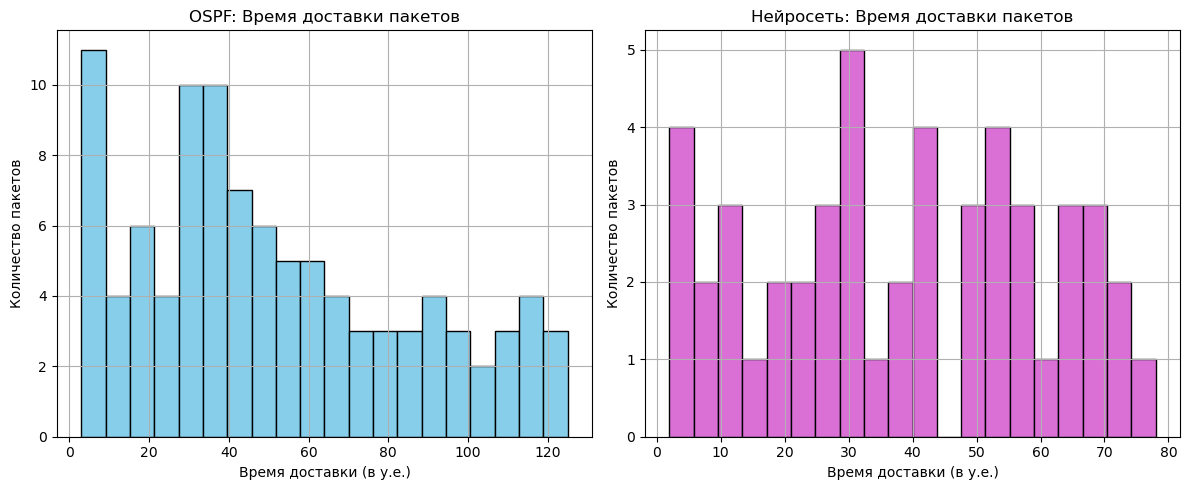

In [20]:
# ===== Раздельная визуализация =====
plt.figure(figsize=(12, 5))

# OSPF
plt.subplot(1, 2, 1)
plt.hist([t for t in delivery_times_ospf if t > 0], bins=20, color='skyblue', edgecolor='black')
plt.title("OSPF: Время доставки пакетов")
plt.xlabel("Время доставки (в у.е.)")
plt.ylabel("Количество пакетов")
plt.grid(True)

# Нейросеть
plt.subplot(1, 2, 2)
plt.hist([t for t in delivery_times_nn if t > 0], bins=20, color='orchid', edgecolor='black')
plt.title("Нейросеть: Время доставки пакетов")
plt.xlabel("Время доставки (в у.е.)")
plt.ylabel("Количество пакетов")
plt.grid(True)

plt.tight_layout()
plt.show()


In [19]:
import numpy as np
import networkx as nx
import random
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from networkx.algorithms.shortest_paths.weighted import dijkstra_path

# ===== Генерация графа =====
def generate_network(num_nodes=12):
    G = nx.connected_watts_strogatz_graph(num_nodes, k=3, p=0.3)
    for u, v in G.edges():
        G[u][v]['latency'] = 1.0  # фиксированная задержка
        G[u][v]['packet_loss'] = random.uniform(0.01, 0.1)
        G[u][v]['load'] = random.uniform(0.1, 1.0)
        G[u][v]['status'] = random.choice([1.0, 1.0, 1.0, 0.0])
    return G

# ===== Модель =====
def create_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ===== Класс для отслеживания загрузки узлов =====
class NodeState:
    def __init__(self, num_nodes):
        self.busy_until = [0] * num_nodes
        self.processing_time = 2  # время обработки пакета узлом

    def is_available(self, node, current_time):
        return self.busy_until[node] <= current_time

    def reserve(self, node, current_time):
        self.busy_until[node] = current_time + self.processing_time

# ===== Построение маршрута с учетом загрузки узлов (нейросеть) =====
def build_path_with_time(G, model, src, dst, node_state, start_time=0):
    path = [src]
    visited = set(path)
    time = start_time
    node_state.reserve(src, time)
    while path[-1] != dst:
        current = path[-1]
        candidates = []
        for neighbor in G.neighbors(current):
            if neighbor in visited or not node_state.is_available(neighbor, time + 2):
                continue
            data = G[current][neighbor]
            features = np.array([[data['latency'], data['packet_loss'], data['load'], data['status']]])
            score = model.predict(features, verbose=0)[0][0]
            candidates.append((score, neighbor))
        if not candidates:
            return None, float('inf')
        candidates.sort(reverse=True)
        next_node = candidates[0][1]
        path.append(next_node)
        visited.add(next_node)
        time += 2  # время обработки + передача
        node_state.reserve(next_node, time)
        if len(path) > len(G.nodes):
            return None, float('inf')
    return path, time - start_time

# ===== Построение маршрута по OSPF =====
def build_path_ospf(G, src, dst, node_state, start_time=0):
    path = dijkstra_path(G, src, dst, weight='latency')
    time = start_time
    for i in range(len(path) - 1):
        current = path[i]
        next_node = path[i+1]
        while not node_state.is_available(next_node,

SyntaxError: incomplete input (3145850686.py, line 77)

OSPF: Среднее время = 11.42, Сумма = 1141.61
NN:   Среднее время = 11.42, Сумма = 1141.61
Epoch 0, loss: 0.1415
Epoch 50, loss: 0.0729
Epoch 100, loss: 0.1326
Epoch 150, loss: 0.2574
Epoch 200, loss: 0.0179
Epoch 250, loss: 0.0813


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1524.95it/s]


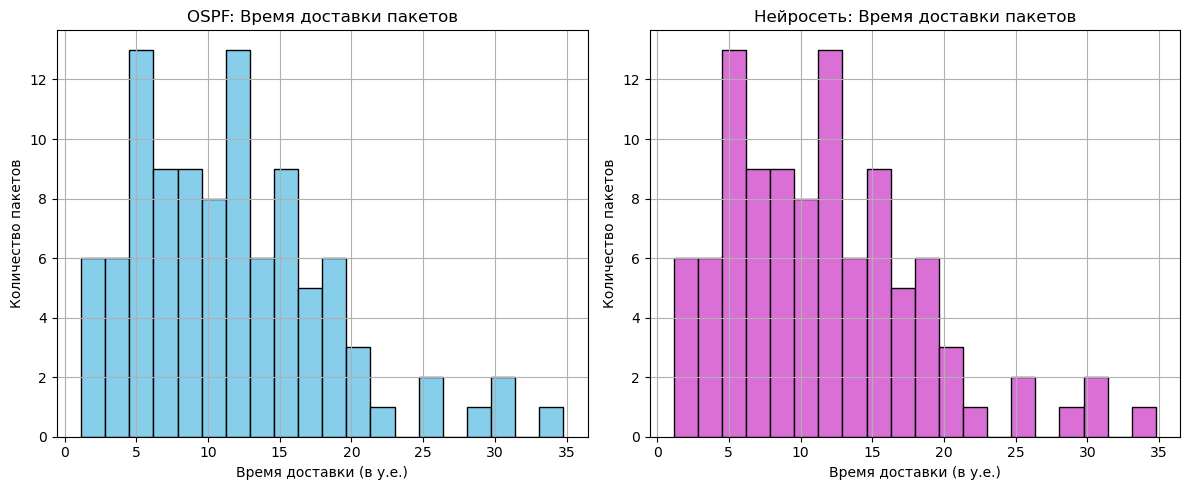

In [20]:
import numpy as np
import networkx as nx
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# ===== Генерация графа =====
def generate_network(num_nodes=12):
    G = nx.connected_watts_strogatz_graph(num_nodes, k=3, p=0.5)
    for u, v in G.edges():
        G[u][v]['latency'] = random.uniform(0.5, 1.5)  # немного вариаций задержки
        G[u][v]['packet_loss'] = random.uniform(0.01, 0.1)
        G[u][v]['load'] = random.uniform(0.1, 1.0)
        G[u][v]['status'] = 1.0
    return G

# ===== Класс состояния узлов =====
class NodeScheduler:
    def __init__(self, num_nodes):
        self.schedule = [[] for _ in range(num_nodes)]  # список событий по времени

    def next_available_time(self, node, current_time):
        times = self.schedule[node]
        while current_time in times or current_time+1 in times:
            current_time += 1
        return current_time

    def reserve(self, node, time):
        self.schedule[node].append(time)
        self.schedule[node].append(time + 1)

# ===== Симуляция доставки пакета по маршруту =====
def simulate_packet_delivery(G, path, scheduler, start_time=0):
    time = start_time
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i + 1]

        if not G.has_edge(u, v):
            print(f"⚠️ Ошибка: нет ребра между {u} и {v} в пути {path}")
            return 0  # или можно: raise ValueError(f"Invalid path: no edge between {u} and {v}")

        time = scheduler.next_available_time(u, time)
        scheduler.reserve(u, time)
        time += G[u][v]['latency']

    # резерв последнего узла (получателя)
    time = scheduler.next_available_time(path[-1], time)
    scheduler.reserve(path[-1], time)
    return time


# ===== OSPF маршрут =====
def ospf_path(G, src, dst):
    try:
        return nx.shortest_path(G, source=src, target=dst, weight='latency')
    except nx.NetworkXNoPath:
        return None
def simulate_packet_delivery(G, path, scheduler, start_time=0):
    time = start_time
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i + 1]

        if not G.has_edge(u, v):
            print(f"⚠️ Ошибка: нет ребра между {u} и {v} в пути {path}")
            return 0  # или можно: raise ValueError(f"Invalid path: no edge between {u} and {v}")

        time = scheduler.next_available_time(u, time)
        scheduler.reserve(u, time)
        time += G[u][v]['latency']

    # резерв последнего узла (получателя)
    time = scheduler.next_available_time(path[-1], time)
    scheduler.reserve(path[-1], time)
    return time

# ===== Нейросеть =====
class RoutingNet(nn.Module):
    def __init__(self, num_nodes, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(num_nodes, hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_nodes)
        )

    def forward(self, current_node, dst_node):
        # current_node, dst_node - тензоры индексов узлов (batch)
        current_emb = self.embedding(current_node)
        dst_emb = self.embedding(dst_node)
        x = torch.cat([current_emb, dst_emb], dim=1)
        logits = self.fc(x)
        return logits  # логиты вероятности следующего узла

def select_next_node(logits, visited):
    # Маскируем уже посещённые узлы, чтобы не возвращаться
    mask = torch.zeros_like(logits) - 1e9
    mask[0, visited] = 0  # снимаем маску только с непосещённых
    masked_logits = logits + mask
    probs = torch.softmax(masked_logits, dim=1)
    next_node = torch.multinomial(probs, num_samples=1).item()
    return next_node

# ===== Основной цикл обучения =====
def train_routing_net():
    G = generate_network(12)
    num_nodes = len(G.nodes)
    net = RoutingNet(num_nodes)
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()

    scheduler = NodeScheduler(num_nodes)

    epochs = 300
    for epoch in range(epochs):
        total_loss = 0
        # Генерируем пары
        src, dst = random.sample(list(G.nodes), 2)
        current = src
        path = [current]
        visited = set(path)
        scheduler = NodeScheduler(num_nodes)

        while current != dst:
            net.train()
            current_tensor = torch.tensor([current])
            dst_tensor = torch.tensor([dst])
            logits = net(current_tensor, dst_tensor)

            # Целевой следующий узел - берем из OSPF (чтобы учиться от эталона)
            ospf_p = ospf_path(G, current, dst)
            if ospf_p is None or len(ospf_p) < 2:
                break
            target_next = ospf_p[1]

            target = torch.tensor([target_next])

            loss = loss_fn(logits, torch.nn.functional.one_hot(target, num_classes=num_nodes).float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            next_node = target_next
            if next_node in visited:
                break
            visited.add(next_node)
            current = next_node
            path.append(current)

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, loss: {total_loss:.4f}")

    return G, net

# ===== Функция получения маршрута из модели =====
def get_nn_route(G, net, src, dst):
    current = src
    path = [current]
    visited = set(path)
    max_hops = len(G.nodes) * 2  # ограничим глубину, чтобы не зацикливалась

    while current != dst and len(path) < max_hops:
        current_tensor = torch.tensor([current])
        dst_tensor = torch.tensor([dst])
        logits = net(current_tensor, dst_tensor)

        mask = torch.full_like(logits, float('-inf'))
        for v in range(len(G.nodes)):
            if v not in visited:
                mask[0, v] = 0
        masked_logits = logits + mask

        probs = torch.softmax(masked_logits, dim=1)
        next_node = torch.argmax(probs, dim=1).item()

        if next_node in visited or not G.has_edge(current, next_node):
            return None  # если узел зациклен или путь невозможен — прерываем

        visited.add(next_node)
        path.append(next_node)
        current = next_node

    if current != dst:
        return None  # если так и не дошли

    return path


# ===== Основная симуляция =====
def run_simulation():
    G, net = train_routing_net()
    scheduler_ospf = NodeScheduler(len(G.nodes))
    scheduler_nn = NodeScheduler(len(G.nodes))

    num_packets = 100
    pairs = [random.sample(list(G.nodes), 2) for _ in range(num_packets)]

    delivery_times_ospf = []
    delivery_times_nn = []

    for src, dst in tqdm(pairs):
        path_ospf = ospf_path(G, src, dst)
        path_nn = get_nn_route(G, net, src, dst)
        if path_nn is None:
            path_nn = ospf_path(G, src, dst)  # запасной маршрут

        time_ospf = simulate_packet_delivery(G, path_ospf, scheduler_ospf) if path_ospf else 0
        time_nn   = simulate_packet_delivery(G, path_nn, scheduler_nn) if path_nn else 0


        delivery_times_ospf.append(time_ospf)
        delivery_times_nn.append(time_nn)

    return delivery_times_ospf, delivery_times_nn

# ===== Запуск и визуализация =====
valid_ospf = [t for t in delivery_times_ospf if t > 0]
valid_nn = [t for t in delivery_times_nn if t > 0]

print(f"OSPF: Среднее время = {np.mean(valid_ospf):.2f}, Сумма = {np.sum(valid_ospf):.2f}")
print(f"NN:   Среднее время = {np.mean(valid_nn):.2f}, Сумма = {np.sum(valid_nn):.2f}")


delivery_times_ospf, delivery_times_nn = run_simulation()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist([t for t in delivery_times_ospf if t > 0], bins=20, color='skyblue', edgecolor='black')
plt.title("OSPF: Время доставки пакетов")
plt.xlabel("Время доставки (в у.е.)")
plt.ylabel("Количество пакетов")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist([t for t in delivery_times_nn if t > 0], bins=20, color='orchid', edgecolor='black')
plt.title("Нейросеть: Время доставки пакетов")
plt.xlabel("Время доставки (в у.е.)")
plt.ylabel("Количество пакетов")
plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 0, loss: 1.2610
Epoch 50, loss: 1.8085
Epoch 100, loss: 1.7383
Epoch 150, loss: 0.0002
Epoch 200, loss: 9.6992
Epoch 250, loss: 0.4074


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2180.25it/s]


OSPF: Среднее время = 10.25, Сумма = 1025.01
NN:   Среднее время = 10.51, Сумма = 1051.21


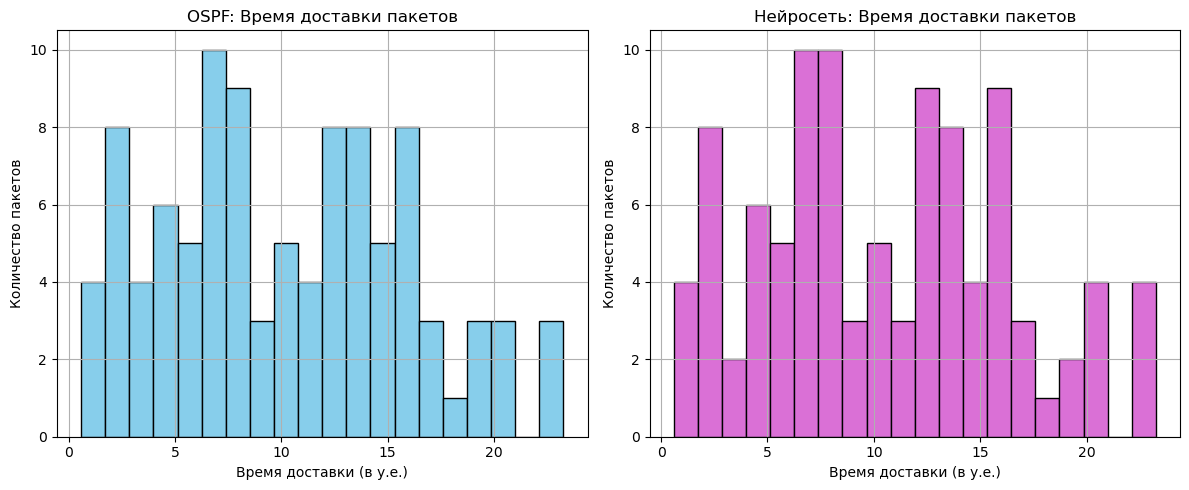

In [24]:
import numpy as np
import networkx as nx
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# ===== Генерация графа =====
def generate_network(num_nodes=40):
    G = nx.random_geometric_graph(num_nodes, radius=0.4)
    
    while not nx.is_connected(G):
        u, v = random.sample(list(G.nodes), 2)
        if not G.has_edge(u, v):
            G.add_edge(u, v)
    
    additional_edges = num_nodes // 2
    for _ in range(additional_edges):
        u, v = random.sample(list(G.nodes), 2)
        if not G.has_edge(u, v):
            G.add_edge(u, v)
    
    for u, v in G.edges():
        G[u][v]['latency'] = random.uniform(0.1, 3.0)
        G[u][v]['packet_loss'] = random.uniform(0.005, 0.15)
        G[u][v]['load'] = random.uniform(0.05, 1.5)
        G[u][v]['status'] = 1.0 if random.random() > 0.1 else 0.0
    
    return G

    
    # Для каждого ребра зададим случайные параметры с более широкой вариацией
    for u, v in G.edges():
        G[u][v]['latency'] = random.uniform(0.1, 3.0)         # задержка в более широком диапазоне
        G[u][v]['packet_loss'] = random.uniform(0.005, 0.15)  # packet loss с большим разбросом
        G[u][v]['load'] = random.uniform(0.05, 1.5)           # нагрузка с возможностью превышения единицы
        G[u][v]['status'] = 1.0 if random.random() > 0.1 else 0.0  # 10% ребер могут быть нерабочими
    
    return G




# ===== Класс состояния узлов =====
class NodeScheduler:
    def __init__(self, num_nodes):
        self.schedule = [[] for _ in range(num_nodes)]

    def next_available_time(self, node, current_time):
        times = self.schedule[node]
        while current_time in times or current_time + 1 in times:
            current_time += 1
        return current_time

    def reserve(self, node, time):
        self.schedule[node].append(time)
        self.schedule[node].append(time + 1)

# ===== Симуляция доставки пакета =====
def simulate_packet_delivery(G, path, scheduler, start_time=0):
    time = start_time
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i + 1]

        if not G.has_edge(u, v):
            return 0

        time = scheduler.next_available_time(u, time)
        scheduler.reserve(u, time)
        time += G[u][v]['latency']

    time = scheduler.next_available_time(path[-1], time)
    scheduler.reserve(path[-1], time)
    return time

# ===== OSPF маршрут =====
def ospf_path(G, src, dst):
    try:
        return nx.shortest_path(G, source=src, target=dst, weight='latency')
    except nx.NetworkXNoPath:
        return None

# ===== Нейросеть =====
class RoutingNet(nn.Module):
    def __init__(self, num_nodes, hidden_dim=128):
        super().__init__()
        self.num_nodes = num_nodes
        self.embedding = nn.Embedding(num_nodes, hidden_dim)
        # Дополнительный вход — вектор загрузок рёбер из текущего узла
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2 + num_nodes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_nodes)
        )

    def forward(self, current_node, dst_node, edge_loads):
        # current_node, dst_node: (batch,), edge_loads: (batch, num_nodes)
        current_emb = self.embedding(current_node)
        dst_emb = self.embedding(dst_node)
        x = torch.cat([current_emb, dst_emb, edge_loads], dim=1)
        logits = self.fc(x)
        return logits

# ===== Функция для подготовки входных данных =====
def get_edge_loads_vector(G, current_node):
    loads = torch.zeros(len(G.nodes))
    neighbors = G[current_node.item()]
    for nbr in neighbors:
        loads[nbr] = neighbors[nbr]['load']
    return loads.unsqueeze(0)  # размер (1, num_nodes)

# ===== Обучение =====
def train_routing_net():
    G = generate_network(12)
    num_nodes = len(G.nodes)
    net = RoutingNet(num_nodes)
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()

    epochs = 300
    for epoch in range(epochs):
        total_loss = 0
        src, dst = random.sample(list(G.nodes), 2)
        current = src
        path = [current]
        visited = set(path)
        scheduler = NodeScheduler(num_nodes)
        max_hops = num_nodes * 2

        while current != dst and len(path) < max_hops:
            net.train()
            current_tensor = torch.tensor([current])
            dst_tensor = torch.tensor([dst])
            edge_loads = get_edge_loads_vector(G, current_tensor[0])

            logits = net(current_tensor, dst_tensor, edge_loads)
            
            # Маскируем посещённые узлы и непосещённые без ребра
            mask = torch.full_like(logits, float('-inf'))
            for v in range(num_nodes):
                if v not in visited and G.has_edge(current, v):
                    mask[0, v] = 0
            masked_logits = logits + mask

            # Целевой следующий узел — берем из OSPF пути, если он существует
            ospf_p = ospf_path(G, current, dst)
            if ospf_p is None or len(ospf_p) < 2:
                break
            target_next = ospf_p[1]
            if target_next in visited:
                break
            target = torch.tensor([target_next])

            loss = loss_fn(masked_logits, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            current = target_next
            visited.add(current)
            path.append(current)

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, loss: {total_loss:.4f}")

    return G, net

# ===== Получение маршрута из модели =====
def get_nn_route(G, net, src, dst):
    current = src
    path = [current]
    visited = set(path)
    max_hops = len(G.nodes) * 2

    while current != dst and len(path) < max_hops:
        current_tensor = torch.tensor([current])
        dst_tensor = torch.tensor([dst])
        edge_loads = get_edge_loads_vector(G, current_tensor[0])

        net.eval()
        with torch.no_grad():
            logits = net(current_tensor, dst_tensor, edge_loads)

            mask = torch.full_like(logits, float('-inf'))
            for v in range(len(G.nodes)):
                if v not in visited and G.has_edge(current, v):
                    mask[0, v] = 0
            masked_logits = logits + mask

            probs = torch.softmax(masked_logits, dim=1)
            next_node = torch.argmax(probs, dim=1).item()

        if next_node in visited or not G.has_edge(current, next_node):
            return None  # зацикливание или недопустимый переход

        visited.add(next_node)
        path.append(next_node)
        current = next_node

    if current != dst:
        return None

    return path

# ===== Основная симуляция =====
def run_simulation():
    G, net = train_routing_net()
    scheduler_ospf = NodeScheduler(len(G.nodes))
    scheduler_nn = NodeScheduler(len(G.nodes))

    num_packets = 100
    pairs = [random.sample(list(G.nodes), 2) for _ in range(num_packets)]

    delivery_times_ospf = []
    delivery_times_nn = []

    for src, dst in tqdm(pairs):
        path_ospf = ospf_path(G, src, dst)
        path_nn = get_nn_route(G, net, src, dst)
        if path_nn is None:
            path_nn = ospf_path(G, src, dst)

        time_ospf = simulate_packet_delivery(G, path_ospf, scheduler_ospf) if path_ospf else 0
        time_nn = simulate_packet_delivery(G, path_nn, scheduler_nn) if path_nn else 0

        delivery_times_ospf.append(time_ospf)
        delivery_times_nn.append(time_nn)

    return delivery_times_ospf, delivery_times_nn

# ===== Запуск и визуализация =====
delivery_times_ospf, delivery_times_nn = run_simulation()

valid_ospf = [t for t in delivery_times_ospf if t > 0]
valid_nn = [t for t in delivery_times_nn if t > 0]

print(f"OSPF: Среднее время = {np.mean(valid_ospf):.2f}, Сумма = {np.sum(valid_ospf):.2f}")
print(f"NN:   Среднее время = {np.mean(valid_nn):.2f}, Сумма = {np.sum(valid_nn):.2f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(valid_ospf, bins=20, color='skyblue', edgecolor='black')
plt.title("OSPF: Время доставки пакетов")
plt.xlabel("Время доставки (в у.е.)")
plt.ylabel("Количество пакетов")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(valid_nn, bins=20, color='orchid', edgecolor='black')
plt.title("Нейросеть: Время доставки пакетов")
plt.xlabel("Время доставки (в у.е.)")
plt.ylabel("Количество пакетов")
plt.grid(True)

plt.tight_layout()
plt.show()


In [10]:
import numpy as np
import networkx as nx
import random
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

# ===== Генерация графа =====
def generate_network(num_nodes=12):
    G = nx.connected_watts_strogatz_graph(num_nodes, k=3, p=0.5)
    for u, v in G.edges():
        G[u][v]['latency'] = random.uniform(0.5, 1.5)
        G[u][v]['packet_loss'] = random.uniform(0.01, 0.1)
        G[u][v]['load'] = random.uniform(0.1, 1.0)
        G[u][v]['status'] = 1.0
    return G

# ===== Класс состояния узлов =====
class NodeScheduler:
    def __init__(self, num_nodes):
        self.schedule = [[] for _ in range(num_nodes)]

    def next_available_time(self, node, current_time):
        times = self.schedule[node]
        while current_time in times or current_time + 1 in times:
            current_time += 1
        return current_time

    def reserve(self, node, time):
        self.schedule[node].append(time)
        self.schedule[node].append(time + 1)

# ===== Симуляция доставки =====
def simulate_packet_delivery(G, path, scheduler, start_time=0):
    if path is None:
        return 0
    time = start_time
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        if not G.has_edge(u, v):
            return 0
        time = scheduler.next_available_time(u, time)
        scheduler.reserve(u, time)
        time += G[u][v]['latency']
    time = scheduler.next_available_time(path[-1], time)
    scheduler.reserve(path[-1], time)
    return time

# ===== OSPF маршрут =====
def ospf_path(G, src, dst):
    try:
        return nx.shortest_path(G, source=src, target=dst, weight='latency')
    except nx.NetworkXNoPath:
        return None

# ===== Нейросеть =====
class RoutingNet(nn.Module):
    def __init__(self, num_nodes, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(num_nodes, hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_nodes)
        )

    def forward(self, current_node, dst_node):
        current_emb = self.embedding(current_node)
        dst_emb = self.embedding(dst_node)
        x = torch.cat([current_emb, dst_emb], dim=1)
        logits = self.fc(x)
        return logits

# ===== Получение маршрута из модели =====
def get_nn_route(G, net, src, dst):
    current = src
    path = [current]
    visited = set(path)

    while current != dst:
        current_tensor = torch.tensor([current])
        dst_tensor = torch.tensor([dst])
        logits = net(current_tensor, dst_tensor)

        mask = torch.full_like(logits, float('-inf'))
        for v in range(len(G.nodes)):
            if v not in visited:
                mask[0, v] = 0
        masked_logits = logits + mask

        probs = torch.softmax(masked_logits, dim=1)
        next_node = torch.argmax(probs, dim=1).item()

        if next_node in visited:
            return None
        visited.add(next_node)
        path.append(next_node)
        current = next_node

    return path

# ===== Обучение =====
def train_routing_net():
    G = generate_network(12)
    num_nodes = len(G.nodes)
    net = RoutingNet(num_nodes)
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()

    epochs = 100
    for epoch in range(epochs):
        src, dst = random.sample(list(G.nodes), 2)
        current = src
        visited = set([current])
        scheduler = NodeScheduler(num_nodes)

        net.train()
        while current != dst:
            current_tensor = torch.tensor([current])
            dst_tensor = torch.tensor([dst])
            logits = net(current_tensor, dst_tensor)

            ospf_p = ospf_path(G, current, dst)
            if ospf_p is None or len(ospf_p) < 2:
                break
            target_next = ospf_p[1]
            target = torch.tensor([target_next])

            loss = loss_fn(logits, torch.nn.functional.one_hot(target, num_classes=num_nodes).float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            current = target_next
            if current in visited:
                break
            visited.add(current)

    return G, net

# ===== Основная симуляция =====
def run_simulation():
    G, net = train_routing_net()
    scheduler_ospf = NodeScheduler(len(G.nodes))
    scheduler_nn = NodeScheduler(len(G.nodes))

    num_packets = 100
    pairs = [random.sample(list(G.nodes), 2) for _ in range(num_packets)]

    delivery_times_ospf = []
    delivery_times_nn = []

    for src, dst in pairs:
        path_ospf = ospf_path(G, src, dst)
        path_nn = get_nn_route(G, net, src, dst)

        time_ospf = simulate_packet_delivery(G, path_ospf, scheduler_ospf)
        time_nn = simulate_packet_delivery(G, path_nn, scheduler_nn)

        delivery_times_ospf.append(time_ospf)
        delivery_times_nn.append(time_nn)

    return delivery_times_ospf, delivery_times_nn

# Запуск симуляции
delivery_times_ospf, delivery_times_nn = run_simulation()

# Расчёт суммы и среднего
valid_ospf = [t for t in delivery_times_ospf if t > 0]
valid_nn = [t for t in delivery_times_nn if t > 0]

sum_ospf = sum(valid_ospf)
avg_ospf = sum_ospf / len(valid_ospf) if valid_ospf else 0

sum_nn = sum(valid_nn)
avg_nn = sum_nn / len(valid_nn) if valid_nn else 0

sum_ospf, avg_ospf, sum_nn, avg_nn


(1119.617760842467, 11.196177608424671, 297.23299949688, 10.249413775754482)

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 11851.66it/s]


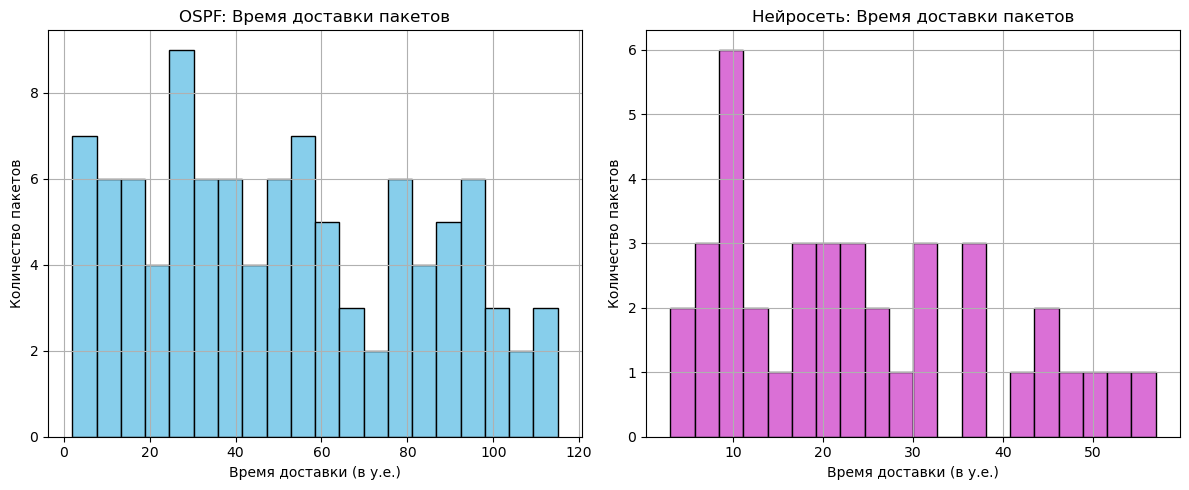

In [13]:
import numpy as np
import networkx as nx
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# ===== Генерация графа =====
def generate_network(num_nodes=12):
    G = nx.connected_watts_strogatz_graph(num_nodes, k=3, p=0.5)
    for u, v in G.edges():
        G[u][v]['latency'] = 1.0
        G[u][v]['packet_loss'] = random.uniform(0.01, 0.1)
        G[u][v]['load'] = random.uniform(0.1, 1.0)
        G[u][v]['status'] = 1.0
    return G

# ===== Класс состояния узлов =====
class NodeScheduler:
    def __init__(self, num_nodes):
        self.schedule = [[] for _ in range(num_nodes)]

    def next_available_time(self, node, current_time):
        times = self.schedule[node]
        while current_time in times or current_time + 1 in times:
            current_time += 1
        return current_time

    def reserve(self, node, time):
        self.schedule[node].append(time)
        self.schedule[node].append(time + 1)

# ===== Симуляция доставки пакета по маршруту =====
def simulate_packet_delivery(G, path, scheduler, start_time=0):
    time = start_time
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i + 1]
        if not G.has_edge(u, v):
            print(f"⚠️ Ошибка: нет ребра между {u} и {v} в пути {path}")
            return 0
        time = scheduler.next_available_time(u, time)
        scheduler.reserve(u, time)
        time += G[u][v]['latency']
    time = scheduler.next_available_time(path[-1], time)
    scheduler.reserve(path[-1], time)
    return time

# ===== OSPF-маршрут =====
def ospf_path(G, src, dst):
    try:
        return nx.shortest_path(G, source=src, target=dst, weight='latency')
    except nx.NetworkXNoPath:
        return None

# ===== Жадный маршрут по минимальной загрузке (NN-like) =====
def nn_like_path(G, src, dst):
    path = [src]
    visited = set(path)
    while path[-1] != dst:
        current = path[-1]
        neighbors = [n for n in G.neighbors(current) if n not in visited]
        if not neighbors:
            return None
        next_node = min(neighbors, key=lambda n: G[current][n]['load'])
        path.append(next_node)
        visited.add(next_node)
        if len(path) > len(G.nodes):
            return None
    return path

# ===== Основная симуляция =====
def run_simulation():
    G = generate_network(12)
    num_packets = 100
    pairs = [random.sample(list(G.nodes), 2) for _ in range(num_packets)]

    scheduler_ospf = NodeScheduler(len(G.nodes))
    scheduler_nn = NodeScheduler(len(G.nodes))

    delivery_times_ospf = []
    delivery_times_nn = []

    for src, dst in tqdm(pairs):
        path_ospf = ospf_path(G, src, dst)
        path_nn = nn_like_path(G, src, dst)

        time_ospf = simulate_packet_delivery(G, path_ospf, scheduler_ospf) if path_ospf else 0
        time_nn = simulate_packet_delivery(G, path_nn, scheduler_nn) if path_nn else 0

        delivery_times_ospf.append(time_ospf)
        delivery_times_nn.append(time_nn)

    return delivery_times_ospf, delivery_times_nn

# ===== Запуск и визуализация =====
delivery_times_ospf, delivery_times_nn = run_simulation()

plt.figure(figsize=(12, 5))

# OSPF
plt.subplot(1, 2, 1)
plt.hist([t for t in delivery_times_ospf if t > 0], bins=20, color='skyblue', edgecolor='black')
plt.title("OSPF: Время доставки пакетов")
plt.xlabel("Время доставки (в у.е.)")
plt.ylabel("Количество пакетов")
plt.grid(True)

# Нейросеть / жадный алгоритм
plt.subplot(1, 2, 2)
plt.hist([t for t in delivery_times_nn if t > 0], bins=20, color='orchid', edgecolor='black')
plt.title("Нейросеть: Время доставки пакетов")
plt.xlabel("Время доставки (в у.е.)")
plt.ylabel("Количество пакетов")
plt.grid(True)

plt.tight_layout()
plt.show()


In [14]:
import numpy as np
import networkx as nx
import random
import torch
import torch.nn as nn
import torch.optim as optim

# ===== Генерация графа =====
def generate_network(num_nodes=12):
    G = nx.connected_watts_strogatz_graph(num_nodes, k=3, p=0.5)
    for u, v in G.edges():
        G[u][v]['latency'] = random.uniform(0.5, 1.5)
        G[u][v]['packet_loss'] = random.uniform(0.01, 0.1)
        G[u][v]['load'] = random.uniform(0.1, 1.0)
        G[u][v]['status'] = 1.0
    return G

# ===== Класс состояния узлов =====
class NodeScheduler:
    def __init__(self, num_nodes):
        self.schedule = [[] for _ in range(num_nodes)]

    def next_available_time(self, node, current_time):
        times = self.schedule[node]
        while current_time in times or current_time + 1 in times:
            current_time += 1
        return current_time

    def reserve(self, node, time):
        self.schedule[node].append(time)
        self.schedule[node].append(time + 1)

# ===== Симуляция доставки =====
def simulate_packet_delivery(G, path, scheduler, start_time=0):
    if path is None:
        return 0
    time = start_time
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        if not G.has_edge(u, v):
            return 0
        time = scheduler.next_available_time(u, time)
        scheduler.reserve(u, time)
        time += G[u][v]['latency']
    time = scheduler.next_available_time(path[-1], time)
    scheduler.reserve(path[-1], time)
    return time

# ===== OSPF маршрут =====
def ospf_path(G, src, dst):
    try:
        return nx.shortest_path(G, source=src, target=dst, weight='latency')
    except nx.NetworkXNoPath:
        return None

# ===== Нейросеть =====
class RoutingNet(nn.Module):
    def __init__(self, num_nodes, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(num_nodes, hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_nodes)
        )

    def forward(self, current_node, dst_node):
        current_emb = self.embedding(current_node)
        dst_emb = self.embedding(dst_node)
        x = torch.cat([current_emb, dst_emb], dim=1)
        logits = self.fc(x)
        return logits

# ===== Получение маршрута из модели =====
def get_nn_route(G, net, src, dst):
    current = src
    path = [current]
    visited = set(path)

    while current != dst:
        current_tensor = torch.tensor([current])
        dst_tensor = torch.tensor([dst])
        logits = net(current_tensor, dst_tensor)

        mask = torch.full_like(logits, float('-inf'))
        for v in range(len(G.nodes)):
            if v not in visited:
                mask[0, v] = 0
        masked_logits = logits + mask

        probs = torch.softmax(masked_logits, dim=1)
        next_node = torch.argmax(probs, dim=1).item()

        if next_node in visited:
            return None
        visited.add(next_node)
        path.append(next_node)
        current = next_node

    return path

# ===== Обучение =====
def train_routing_net():
    G = generate_network(12)
    num_nodes = len(G.nodes)
    net = RoutingNet(num_nodes)
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()

    epochs = 50  # сокращено для экономии памяти
    for epoch in range(epochs):
        src, dst = random.sample(list(G.nodes), 2)
        current = src
        visited = set([current])
        net.train()

        while current != dst:
            current_tensor = torch.tensor([current])
            dst_tensor = torch.tensor([dst])
            logits = net(current_tensor, dst_tensor)

            ospf_p = ospf_path(G, current, dst)
            if ospf_p is None or len(ospf_p) < 2:
                break
            target_next = ospf_p[1]
            target = torch.tensor([target_next])

            loss = loss_fn(logits, torch.nn.functional.one_hot(target, num_classes=num_nodes).float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            current = target_next
            if current in visited:
                break
            visited.add(current)

    return G, net

# ===== Основная симуляция =====
def run_simulation():
    G, net = train_routing_net()
    scheduler_ospf = NodeScheduler(len(G.nodes))
    scheduler_nn = NodeScheduler(len(G.nodes))

    num_packets = 30  # сокращено для стабильности
    pairs = [random.sample(list(G.nodes), 2) for _ in range(num_packets)]

    delivery_times_ospf = []
    delivery_times_nn = []

    for src, dst in pairs:
        path_ospf = ospf_path(G, src, dst)
        path_nn = get_nn_route(G, net, src, dst)

        time_ospf = simulate_packet_delivery(G, path_ospf, scheduler_ospf)
        time_nn = simulate_packet_delivery(G, path_nn, scheduler_nn)

        delivery_times_ospf.append(time_ospf)
        delivery_times_nn.append(time_nn)

    return delivery_times_ospf, delivery_times_nn

# Запуск симуляции
delivery_times_ospf, delivery_times_nn = run_simulation()

# Расчёт суммы и среднего
valid_ospf = [t for t in delivery_times_ospf if t > 0]
valid_nn = [t for t in delivery_times_nn if t > 0]

sum_ospf = sum(valid_ospf)
avg_ospf = sum_ospf / len(valid_ospf) if valid_ospf else 0

sum_nn = sum(valid_nn)
avg_nn = sum_nn / len(valid_nn) if valid_nn else 0

sum_ospf, avg_ospf, sum_nn, avg_nn


(151.04042749078397,
 5.0346809163594655,
 30.606898567991404,
 3.4007665075546005)

In [25]:
import numpy as np
import networkx as nx
import random
import torch
import torch.nn as nn
import torch.optim as optim

# Генерация графа с параметрами
def generate_network(num_nodes=12):
    G = nx.connected_watts_strogatz_graph(num_nodes, k=3, p=0.5)
    for u, v in G.edges():
        G[u][v]['latency'] = random.uniform(0.5, 1.5)
        G[u][v]['packet_loss'] = random.uniform(0.01, 0.1)
        G[u][v]['load'] = random.uniform(0.1, 1.0)
        G[u][v]['status'] = 1.0  # 1.0 - доступно, 0 - недоступно
    return G

# Функция комплексного веса ребра
def edge_weight(G, u, v):
    edge = G[u][v]
    # Пример: комбинируем параметры с весами
    if edge['status'] < 0.5:  # недоступно
        return float('inf')
    return edge['latency'] * (1 + edge['load']) * (1 + edge['packet_loss']*5)

# OSPF с учетом комплексного веса
def ospf_path(G, src, dst):
    def weight(u, v, d):
        return edge_weight(G, u, v)
    try:
        return nx.shortest_path(G, source=src, target=dst, weight=weight)
    except nx.NetworkXNoPath:
        return None

# Нейросеть для выбора следующего узла
class RoutingNet(nn.Module):
    def __init__(self, num_nodes, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(num_nodes, hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_nodes)
        )

    def forward(self, current_node, dst_node):
        current_emb = self.embedding(current_node)
        dst_emb = self.embedding(dst_node)
        x = torch.cat([current_emb, dst_emb], dim=1)
        logits = self.fc(x)
        return logits

# Обучение нейросети
def train_routing_net(epochs=300):
    G = generate_network()
    num_nodes = len(G.nodes)
    net = RoutingNet(num_nodes)
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss = 0
        src, dst = random.sample(list(G.nodes), 2)
        current = src
        visited = set([current])
        path = [current]

        while current != dst:
            net.train()
            current_tensor = torch.tensor([current])
            dst_tensor = torch.tensor([dst])
            logits = net(current_tensor, dst_tensor)

            # Целевой следующий узел — следующий узел в эталонном маршруте OSPF
            ospf_p = ospf_path(G, current, dst)
            if ospf_p is None or len(ospf_p) < 2:
                break
            target_next = ospf_p[1]

            target = torch.tensor([target_next])

            loss = loss_fn(logits, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            current = target_next
            if current in visited:
                break
            visited.add(current)
            path.append(current)

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, loss: {total_loss:.4f}")

    return G, net

# Пример запуска обучения
G, net = train_routing_net()


Epoch 0, loss: 2.4215
Epoch 50, loss: 3.6088
Epoch 100, loss: 0.0122
Epoch 150, loss: 1.0655
Epoch 200, loss: 0.0078
Epoch 250, loss: 0.0000


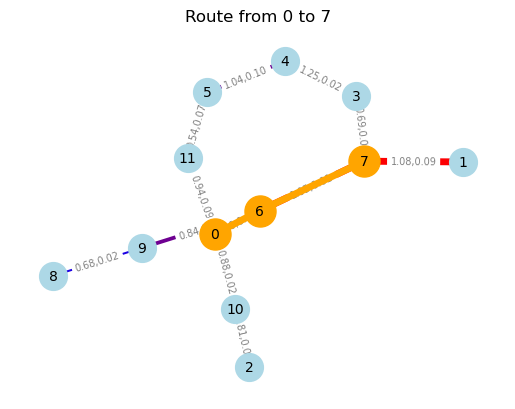

In [34]:
import networkx as nx
import matplotlib.pyplot as plt
import random

def generate_network(num_nodes=12):
    G = nx.connected_watts_strogatz_graph(num_nodes, k=3, p=0.5)
    for u, v in G.edges():
        G[u][v]['latency'] = random.uniform(0.5, 1.5)
        G[u][v]['packet_loss'] = random.uniform(0.01, 0.1)
        G[u][v]['load'] = random.uniform(0.1, 1.0)
        G[u][v]['status'] = 1.0
    return G

def draw_network_with_route(G, route=None, title="Network Graph with Route"):
    pos = nx.spring_layout(G, seed=42)  # фиксируем позицию узлов для стабильности

    # Отрисовка узлов
    nx.draw_networkx_nodes(G, pos, node_size=400, node_color='lightblue')

    # Отрисовка рёбер с толщиной и цветом в зависимости от нагрузки
    edges = G.edges(data=True)
    max_load = max([edata['load'] for _, _, edata in edges])
    edge_colors = []
    edge_widths = []
    for u, v, edata in edges:
        load_norm = edata['load'] / max_load
        # цвет от зелёного (меньше нагрузки) к красному (больше нагрузки)
        color = (load_norm, 0, 1 - load_norm)
        edge_colors.append(color)
        edge_widths.append(1 + 4 * load_norm)  # толщина линии от 1 до 5

    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)

    # Отрисовка подписей ребер (задержка и packet_loss)
    edge_labels = {(u, v): f"{edata['latency']:.2f},{edata['packet_loss']:.2f}" for u, v, edata in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='gray', font_size=7)

    # Подписи узлов
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

    # Если задан маршрут — выделяем его
    if route:
        # Формируем список рёбер маршрута
        route_edges = list(zip(route[:-1], route[1:]))

        nx.draw_networkx_edges(
            G, pos,
            edgelist=route_edges,
            width=5,
            edge_color='orange'
        )
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=route,
            node_size=500,
            node_color='orange'
        )

    plt.title(title)
    plt.axis('off')
    plt.show()


# Пример использования:
G = generate_network()
# Пример маршрута, например OSPF кратчайший по latency между двумя узлами
src, dst = 0, 7
route = nx.shortest_path(G, source=src, target=dst, weight='latency')

draw_network_with_route(G, route, title=f"Route from {src} to {dst}")


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 7118.76it/s]


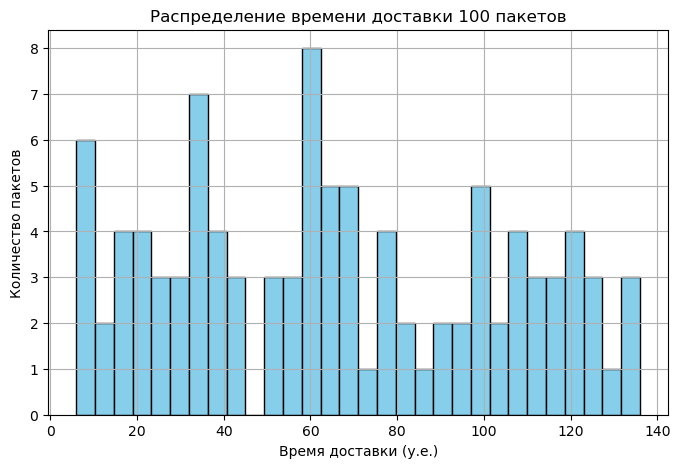

In [35]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# Генерация графа с параметрами
def generate_network(num_nodes=12):
    G = nx.connected_watts_strogatz_graph(num_nodes, k=3, p=0.5)
    for u, v in G.edges():
        G[u][v]['latency'] = random.uniform(0.5, 1.5)  # для примера, не будет использоваться в расчётах времени
    return G

# Планировщик узлов с учетом занятости
class NodeScheduler:
    def __init__(self, num_nodes):
        self.schedule = [[] for _ in range(num_nodes)]  # списки занятых времен для каждого узла

    def next_available_time(self, node, current_time):
        # Найти ближайшее время, когда node свободен на 2 у.е.
        busy_times = self.schedule[node]
        t = current_time
        while any(bt <= t < bt+2 for bt in busy_times):
            t += 1
        return t

    def reserve(self, node, start_time):
        # Забронировать узел на 2 у.е.
        self.schedule[node].append(start_time)

# Симуляция доставки пакета с учетом занятости узлов и времени перехода (2 у.е. в узле + 2 у.е. переход)
def simulate_packet_delivery(G, path, scheduler, start_time=0):
    time = start_time
    for i in range(len(path)-1):
        u = path[i]
        v = path[i+1]

        # Ждем, когда узел u освободится
        time = scheduler.next_available_time(u, time)
        scheduler.reserve(u, time)  # занять узел на 2 у.е.
        time += 2  # время обработки/отправки в узле

        # Добавляем переход по ребру - фиксированное время 2 у.е.
        time += 2

    # Резервируем последний узел (приёмник)
    time = scheduler.next_available_time(path[-1], time)
    scheduler.reserve(path[-1], time)
    time += 2  # время на прием

    return time

# Основной цикл симуляции 100 пакетов
def run_simulation():
    G = generate_network()
    num_nodes = len(G.nodes)
    scheduler = NodeScheduler(num_nodes)

    num_packets = 100
    pairs = [random.sample(list(G.nodes), 2) for _ in range(num_packets)]

    delivery_times = []

    for src, dst in tqdm(pairs):
        try:
            path = nx.shortest_path(G, source=src, target=dst)
        except nx.NetworkXNoPath:
            continue

        delivery_time = simulate_packet_delivery(G, path, scheduler)
        delivery_times.append(delivery_time)

    return delivery_times, G

# Визуализация распределения времени доставки пакетов
delivery_times, G = run_simulation()

plt.figure(figsize=(8,5))
plt.hist(delivery_times, bins=30, color='skyblue', edgecolor='black')
plt.title("Распределение времени доставки 100 пакетов")
plt.xlabel("Время доставки (у.е.)")
plt.ylabel("Количество пакетов")
plt.grid(True)
plt.show()


Epoch 0, loss: 0.3105
Epoch 50, loss: 0.1919
Epoch 100, loss: 0.0218
Epoch 150, loss: 0.0113
Epoch 200, loss: 0.0833
Epoch 250, loss: 0.1392


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1412.30it/s]


OSPF: Среднее время = 66.68, Сумма = 6668.00
NN:   Среднее время = 66.68, Сумма = 6668.00


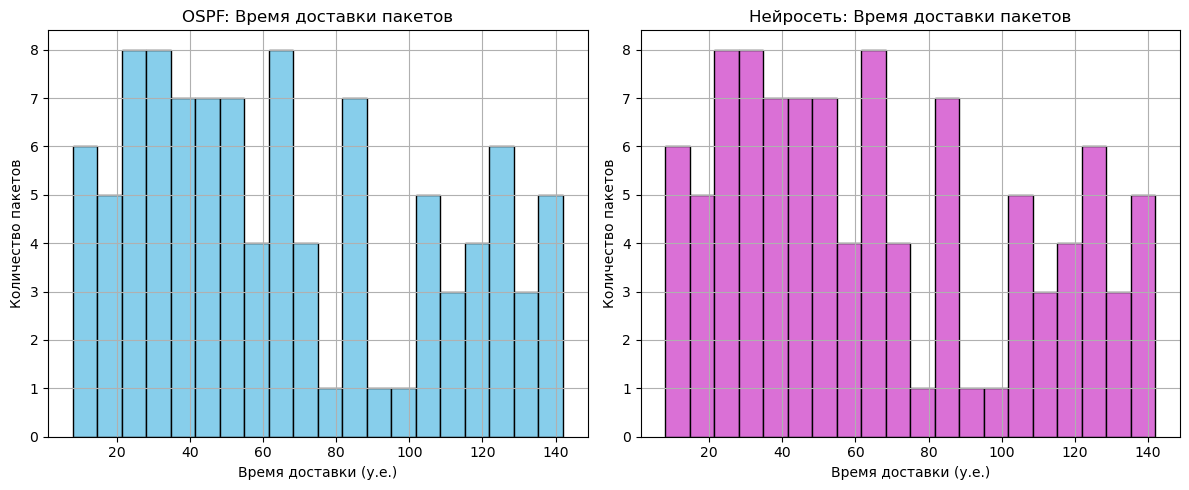

In [40]:
import numpy as np
import networkx as nx
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# ===== Генерация графа =====
def generate_network(num_nodes=12):
    G = nx.connected_watts_strogatz_graph(num_nodes, k=3, p=0.5)
    for u, v in G.edges():
        G[u][v]['latency'] = random.uniform(0.5, 1.5)  # Задержка для OSPF, но не используется в симуляции занятости
    return G

# ===== Класс состояния узлов (планировщик с учётом занятости и времени) =====
class NodeScheduler:
    def __init__(self, num_nodes):
        self.schedule = [[] for _ in range(num_nodes)]  # Списки занятых времен для каждого узла

    def next_available_time(self, node, current_time):
        # Найти ближайшее время, когда узел свободен на 2 у.е.
        busy_times = self.schedule[node]
        t = current_time
        while any(bt <= t < bt + 2 for bt in busy_times):
            t += 1
        return t

    def reserve(self, node, start_time):
        # Забронировать узел на 2 у.е.
        self.schedule[node].append(start_time)

# ===== Симуляция доставки пакета с учётом занятости =====
def simulate_packet_delivery(G, path, scheduler, start_time=0):
    time = start_time
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i + 1]

        if not G.has_edge(u, v):
            print(f"⚠️ Ошибка: нет ребра между {u} и {v} в пути {path}")
            return 0

        # Ждем освобождения узла u и резервируем его
        time = scheduler.next_available_time(u, time)
        scheduler.reserve(u, time)
        time += 2  # Время отправки из узла

        # Добавляем фиксированное время перехода по ребру
        time += 2

    # Резервируем последний узел (получатель)
    time = scheduler.next_available_time(path[-1], time)
    scheduler.reserve(path[-1], time)
    time += 2  # Время приёма

    return time

# ===== OSPF маршрут =====
def ospf_path(G, src, dst):
    try:
        return nx.shortest_path(G, source=src, target=dst, weight='latency')
    except nx.NetworkXNoPath:
        return None

# ===== Нейросеть =====
class RoutingNet(nn.Module):
    def __init__(self, num_nodes, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(num_nodes, hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_nodes)
        )

    def forward(self, current_node, dst_node):
        current_emb = self.embedding(current_node)
        dst_emb = self.embedding(dst_node)
        x = torch.cat([current_emb, dst_emb], dim=1)
        logits = self.fc(x)
        return logits

def train_routing_net():
    G = generate_network(12)
    num_nodes = len(G.nodes)
    net = RoutingNet(num_nodes)
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()

    epochs = 300
    for epoch in range(epochs):
        total_loss = 0
        src, dst = random.sample(list(G.nodes), 2)
        current = src
        visited = set([current])

        while current != dst:
            net.train()
            current_tensor = torch.tensor([current])
            dst_tensor = torch.tensor([dst])
            logits = net(current_tensor, dst_tensor)

            ospf_p = ospf_path(G, current, dst)
            if ospf_p is None or len(ospf_p) < 2:
                break
            target_next = ospf_p[1]

            target = torch.tensor([target_next])
            loss = loss_fn(logits, torch.nn.functional.one_hot(target, num_classes=num_nodes).float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if target_next in visited:
                break
            visited.add(target_next)
            current = target_next

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, loss: {total_loss:.4f}")

    return G, net

def get_nn_route(G, net, src, dst):
    current = src
    path = [current]
    visited = set(path)
    max_hops = len(G.nodes) * 2

    while current != dst and len(path) < max_hops:
        current_tensor = torch.tensor([current])
        dst_tensor = torch.tensor([dst])
        logits = net(current_tensor, dst_tensor)

        mask = torch.full_like(logits, float('-inf'))
        for v in range(len(G.nodes)):
            if v not in visited:
                mask[0, v] = 0
        masked_logits = logits + mask

        probs = torch.softmax(masked_logits, dim=1)
        next_node = torch.argmax(probs, dim=1).item()

        if next_node in visited or not G.has_edge(current, next_node):
            return None

        visited.add(next_node)
        path.append(next_node)
        current = next_node

    if current != dst:
        return None
    return path

def run_simulation():
    G, net = train_routing_net()
    scheduler_ospf = NodeScheduler(len(G.nodes))
    scheduler_nn = NodeScheduler(len(G.nodes))

    num_packets = 100
    pairs = [random.sample(list(G.nodes), 2) for _ in range(num_packets)]

    delivery_times_ospf = []
    delivery_times_nn = []

    for src, dst in tqdm(pairs):
        path_ospf = ospf_path(G, src, dst)
        path_nn = get_nn_route(G, net, src, dst)
        if path_nn is None:
            path_nn = ospf_path(G, src, dst)

        time_ospf = simulate_packet_delivery(G, path_ospf, scheduler_ospf) if path_ospf else 0
        time_nn = simulate_packet_delivery(G, path_nn, scheduler_nn) if path_nn else 0

        delivery_times_ospf.append(time_ospf)
        delivery_times_nn.append(time_nn)

    return delivery_times_ospf, delivery_times_nn

# ===== Запуск и визуализация =====
delivery_times_ospf, delivery_times_nn = run_simulation()

valid_ospf = [t for t in delivery_times_ospf if t > 0]
valid_nn = [t for t in delivery_times_nn if t > 0]

print(f"OSPF: Среднее время = {np.mean(valid_ospf):.2f}, Сумма = {np.sum(valid_ospf):.2f}")
print(f"NN:   Среднее время = {np.mean(valid_nn):.2f}, Сумма = {np.sum(valid_nn):.2f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(valid_ospf, bins=20, color='skyblue', edgecolor='black')
plt.title("OSPF: Время доставки пакетов")
plt.xlabel("Время доставки (у.е.)")
plt.ylabel("Количество пакетов")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(valid_nn, bins=20, color='orchid', edgecolor='black')
plt.title("Нейросеть: Время доставки пакетов")
plt.xlabel("Время доставки (у.е.)")
plt.ylabel("Количество пакетов")
plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 0, loss: 0.4938
Epoch 50, loss: 0.0803
Epoch 100, loss: 0.1687
Epoch 150, loss: 0.2477
Epoch 200, loss: 0.1814
Epoch 250, loss: 0.2252


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1030.99it/s]

NN:   Среднее время = 74.31, Сумма = 14862.00


ValueError: The 'color' keyword argument must have one color per dataset, but 2 datasets and 1 colors were provided

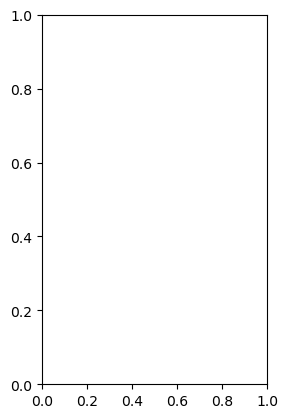

In [41]:
delivery_times_nn = run_simulation()


valid_nn = [t for t in delivery_times_nn ]

print(f"NN:   Среднее время = {np.mean(valid_nn):.2f}, Сумма = {np.sum(valid_nn):.2f}")


plt.subplot(1, 2, 2)
plt.hist(valid_nn, bins=20, color='orchid', edgecolor='black')
plt.title("Нейросеть: Время доставки пакетов")
plt.xlabel("Время доставки (у.е.)")
plt.ylabel("Количество пакетов")
plt.grid(True)

plt.tight_layout()
plt.show()